# Pipeline MLP (Random Search) para previsão de Geração de Energia Solar — Notebook

Este notebook implementa um pipeline completo **usando MLP (sklearn.neural_network.MLPRegressor)** e uma busca aleatória (*random search*) de hiperparâmetros. Ele inclui explicações linha-a-linha sobre variáveis, funções, parâmetros e decisões. Salve o arquivo `solar france.xlsx` no mesmo diretório antes de executar as células.

## 1) Instruções iniciais

- Rode o notebook célula-a-célula.
- Se executar no Colab, instale dependências se necessário (por padrão `scikit-learn`, `pandas`, `matplotlib` já vêm no Colab). Se não tiver, execute: `!pip install -q scikit-learn pandas matplotlib openpyxl joblib`.
- O notebook fará detecção automática de `target` e `date` e gerará lags se não houver preditores adicionais.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import joblib
from pathlib import Path
import random, time, os

## 2) Carregar dados

Leia o arquivo Excel `solar france.xlsx`.

In [2]:
CAMINHO_RAIZ = Path(os.getcwd()).resolve().parent.parent
OUTPUT = CAMINHO_RAIZ / 'out/geracao_energia'
os.makedirs(OUTPUT, exist_ok=True)

solar = pd.read_excel(CAMINHO_RAIZ / 'data' / 'solar france.xlsx')
print('Dimensões do dataset:', solar.shape)
print('Colunas:', solar.columns.tolist())
display(solar.head(8))

Dimensões do dataset: (1439, 2)
Colunas: ['Date and Hour', 'valor']


,Date and Hour,valor
0,2020-01-01 00:00:00+01:00,0.0
1,2020-01-01 01:00:00+01:00,0.0
2,2020-01-01 02:00:00+01:00,0.0
3,2020-01-01 03:00:00+01:00,0.0
4,2020-01-01 04:00:00+01:00,0.0
5,2020-01-01 05:00:00+01:00,0.0
6,2020-01-01 06:00:00+01:00,0.0
7,2020-01-01 07:00:00+01:00,0.0


## 3) Transformar série em problema supervisionado (gerar lags)

Se não houver preditores além de `date` e `target`, geramos *lags* (defasagens) para criar features a partir da própria série temporal. Aqui criamos 8 lags por padrão (pode ajustar). Cada nova feature `lag_k` representa o valor do target há k períodos atrás.

In [3]:
target_col = 'valor'
date_col = 'Date and Hour'
# criar lags automáticos
n_lags = 8
if date_col is not None:
    solar = solar.sort_values(by=date_col).reset_index(drop=True)
for lag in range(1, n_lags+1):
    solar[f'lag_{lag}'] = solar[target_col].shift(lag)
solar = solar.dropna().reset_index(drop=True)
feature_cols = [f'lag_{lag}' for lag in range(1, n_lags+1)]
print('Nenhum preditor encontrado além do target/date. Criadas features:', feature_cols)
# Exibir amostra
display(solar.head(8))

Nenhum preditor encontrado além do target/date. Criadas features: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8']


,Date and Hour,valor,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8
0,2020-01-01 08:00:00+01:00,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-01 09:00:00+01:00,310.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-01 10:00:00+01:00,780.0,310.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-01 11:00:00+01:00,1166.0,780.0,310.0,28.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-01 12:00:00+01:00,1359.0,1166.0,780.0,310.0,28.0,0.0,0.0,0.0,0.0
5,2020-01-01 13:00:00+01:00,1339.0,1359.0,1166.0,780.0,310.0,28.0,0.0,0.0,0.0
6,2020-01-01 14:00:00+01:00,1064.0,1339.0,1359.0,1166.0,780.0,310.0,28.0,0.0,0.0
7,2020-01-01 15:00:00+01:00,592.0,1064.0,1339.0,1359.0,1166.0,780.0,310.0,28.0,0.0


## 4) Separar X (features) e y (target) e criar split (treino/validação/teste)

usamos split cronológico: 50% treino, 25% validação, 25% teste.

In [4]:
# Definir X e y
X = solar[feature_cols].copy()
y = solar[target_col].copy()
print('Shapes: X=', X.shape, ' y=', y.shape)

# Split cronológico
df_sorted = solar.sort_values(by=date_col).reset_index(drop=True)
X_sorted = df_sorted[feature_cols]
y_sorted = df_sorted[target_col]
n = len(df_sorted)
n_train = int(n * 0.50)
n_val = int(n * 0.25)
X_train = X_sorted.iloc[:n_train].reset_index(drop=True)
y_train = y_sorted.iloc[:n_train].reset_index(drop=True)
X_val = X_sorted.iloc[n_train:n_train+n_val].reset_index(drop=True)
y_val = y_sorted.iloc[n_train:n_train+n_val].reset_index(drop=True)
X_test = X_sorted.iloc[n_train+n_val:].reset_index(drop=True)
y_test = y_sorted.iloc[n_train+n_val:].reset_index(drop=True)
print(f'Split cronológico: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}')

Shapes: X= (1431, 8)  y= (1431,)
Split cronológico: train=715, val=357, test=359


## 6) Pré-processamento

- **Imputação**: SimpleImputer(strategy='median') para colunas numéricas (robusto a outliers).
- **Escalonamento**: StandardScaler — redes MLP convergem melhor com features padronizadas.
- **OneHotEncoder** para categóricas, se houver.

Usamos `ColumnTransformer` para aplicar as transformações apenas aos tipos correspondentes.

In [5]:
# Detectar tipos
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print('numeric_cols:', numeric_cols)
print('categorical_cols:', categorical_cols)

num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                  ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, numeric_cols),
                                               ('cat', cat_transformer, categorical_cols)],
                                 remainder='drop')

# Ajustar apenas no treino (evita vazamento)
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

print('Formas após pré-processamento:',
      'X_train_proc=', X_train_proc.shape,
      'X_val_proc=', X_val_proc.shape,
      'X_test_proc=', X_test_proc.shape)

numeric_cols: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8']
categorical_cols: []
Formas após pré-processamento: X_train_proc= (715, 8) X_val_proc= (357, 8) X_test_proc= (359, 8)


## 7) Random Search (busca aleatória) para MLPRegressor

Explicações dos hiperparâmetros que vamos variar:
- `hidden_layer_sizes`: tupla com número de neurônios por camada (ex: (64, 32) → 2 camadas ocultas)
- `activation`: função de ativação (relu, tanh)
- `alpha`: termo de regularização L2 (evita overfitting)
- `learning_rate_init`: taxa inicial de aprendizado
- `solver`: algoritmo de otimização ('adam' recomendado)
- `batch_size`: tamanho do batch

Estratégia: amostrar aleatoriamente N combinações do espaço e treinar cada modelo no conjunto de treino, avaliando no conjunto de validação. Selecionamos o modelo com menor MSE na validação.

In [6]:
# Espaço de busca
param_grid = {
    'hidden_layer_sizes': [(16,), (32,), (64,), (64,32), (128,64)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [1e-2, 1e-3, 1e-4],
    'solver': ['adam'],  # restringimos a 'adam' por estabilidade
    'batch_size': [16, 32, 64]
}

def sample_params(grid):
    return {k: random.choice(v) for k, v in grid.items()}

n_iter = 24  # número de combinações aleatórias a testar (ajuste conforme poder de processamento)
results = []
best = None
best_val_mse = float('inf')

start_time = time.time()
for i in range(n_iter):
    params = sample_params(param_grid)
    print(f'Iter {i+1}/{n_iter} -> {params}')
    mlp = MLPRegressor(hidden_layer_sizes=params['hidden_layer_sizes'],
                       activation=params['activation'],
                       alpha=params['alpha'],
                       learning_rate_init=params['learning_rate_init'],
                       solver=params['solver'],
                       batch_size=params['batch_size'],
                       max_iter=500,
                       early_stopping=True,
                       n_iter_no_change=20,
                       tol=1e-5,
                       random_state=42,
                       verbose=False)
    try:
        mlp.fit(X_train_proc, y_train.values.ravel())
    except Exception as e:
        print('  Treino falhou para esses hiperparâmetros:', e)
        continue
    # Avaliar no conjunto de validação
    y_val_pred = mlp.predict(X_val_proc)
    val_mse = mean_squared_error(y_val, y_val_pred)
    # MAPE poderá ser calculado depois para robustez
    print(f'  Val MSE = {val_mse:.4f}')
    results.append({'params': params, 'val_mse': val_mse, 'model': mlp})
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best = results[-1]
end_time = time.time()
print('\nRandom search concluído em {:.1f} s'.format(end_time - start_time))

Iter 1/24 -> {'hidden_layer_sizes': (128, 64), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 32}
  Val MSE = 57285.6200
Iter 2/24 -> {'hidden_layer_sizes': (128, 64), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 64}
  Val MSE = 14237.1149
Iter 3/24 -> {'hidden_layer_sizes': (64, 32), 'activation': 'tanh', 'alpha': 0.0001, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 32}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 40829.0968
Iter 4/24 -> {'hidden_layer_sizes': (128, 64), 'activation': 'tanh', 'alpha': 0.0001, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 64}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 54073.2444
Iter 5/24 -> {'hidden_layer_sizes': (128, 64), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.0001, 'solver': 'adam', 'batch_size': 64}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 844506.5332
Iter 6/24 -> {'hidden_layer_sizes': (16,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 32}
  Val MSE = 15381.1445
Iter 7/24 -> {'hidden_layer_sizes': (128, 64), 'activation': 'tanh', 'alpha': 0.001, 'learning_rate_init': 0.0001, 'solver': 'adam', 'batch_size': 64}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 844506.5149
Iter 8/24 -> {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.0001, 'solver': 'adam', 'batch_size': 64}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 106732.0934
Iter 9/24 -> {'hidden_layer_sizes': (64,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.0001, 'solver': 'adam', 'batch_size': 32}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 584477.0495
Iter 10/24 -> {'hidden_layer_sizes': (128, 64), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.001, 'solver': 'adam', 'batch_size': 16}
  Val MSE = 10582.2515
Iter 11/24 -> {'hidden_layer_sizes': (16,), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.0001, 'solver': 'adam', 'batch_size': 16}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 853858.4930
Iter 12/24 -> {'hidden_layer_sizes': (128, 64), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.001, 'solver': 'adam', 'batch_size': 64}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 592757.7173
Iter 13/24 -> {'hidden_layer_sizes': (32,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 64}
  Val MSE = 22153.2578
Iter 14/24 -> {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.0001, 'solver': 'adam', 'batch_size': 32}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 64422.0637
Iter 15/24 -> {'hidden_layer_sizes': (16,), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.0001, 'solver': 'adam', 'batch_size': 16}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 651897.3088
Iter 16/24 -> {'hidden_layer_sizes': (32,), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.0001, 'solver': 'adam', 'batch_size': 16}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 449891.3757
Iter 17/24 -> {'hidden_layer_sizes': (128, 64), 'activation': 'tanh', 'alpha': 0.01, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 16}
  Val MSE = 34772.5477
Iter 18/24 -> {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'solver': 'adam', 'batch_size': 16}
  Val MSE = 14826.8089
Iter 19/24 -> {'hidden_layer_sizes': (16,), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.001, 'solver': 'adam', 'batch_size': 32}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 69275.9690
Iter 20/24 -> {'hidden_layer_sizes': (64,), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.001, 'solver': 'adam', 'batch_size': 32}


C:\Users\Felipe Oliveira\Desktop\CIÊNCIA DE DADOS\SÉRIES TEMPORAIS\PROJETO DA DISCIPLINA\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


  Val MSE = 34693.4753
Iter 21/24 -> {'hidden_layer_sizes': (64,), 'activation': 'tanh', 'alpha': 0.0001, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 32}
  Val MSE = 27579.1025
Iter 22/24 -> {'hidden_layer_sizes': (64,), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 64}
  Val MSE = 14891.6862
Iter 23/24 -> {'hidden_layer_sizes': (128, 64), 'activation': 'relu', 'alpha': 0.0001, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 64}
  Val MSE = 14237.1149
Iter 24/24 -> {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.01, 'solver': 'adam', 'batch_size': 32}
  Val MSE = 12055.1434

Random search concluído em 68.8 s


## 8) Seleção do melhor modelo e avaliação final (treino/val/test)

Calculamos MSE e MAPE para treino, validação e teste no melhor modelo encontrado.

In [7]:
# Selecionar melhor
if best is None:
    raise RuntimeError('Nenhum modelo treinado com sucesso.')

best_params = best['params']
best_model = best['model']
print('Melhor hiperparâmetros encontrados:', best_params)
print('Val MSE do melhor:', best['val_mse'])

# Função segura de MAPE (evita divisão por zero)
def safe_mape(y_true, y_pred):
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)
    eps = 1e-8
    denom = np.where(np.abs(y_true) < eps, eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100.0

# Previsões
y_train_pred = best_model.predict(X_train_proc)
y_val_pred = best_model.predict(X_val_proc)
y_test_pred = best_model.predict(X_test_proc)

# Métricas
mse_train = mean_squared_error(y_train, y_train_pred)
mape_train = safe_mape(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mape_val = safe_mape(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mape_test = safe_mape(y_test, y_test_pred)

print('\nMétricas finais:')
print(f'Train - MSE: {mse_train:.4f}, MAPE: {mape_train:.4f}%')
print(f'Val   - MSE: {mse_val:.4f}, MAPE: {mape_val:.4f}%')
print(f'Test  - MSE: {mse_test:.4f}, MAPE: {mape_test:.4f}%')

Melhor hiperparâmetros encontrados: {'hidden_layer_sizes': (128, 64), 'activation': 'relu', 'alpha': 0.01, 'learning_rate_init': 0.001, 'solver': 'adam', 'batch_size': 16}
Val MSE do melhor: 10582.25152435842

Métricas finais:
Train - MSE: 2658.5765, MAPE: 34803782807.7240%
Val   - MSE: 10582.2515, MAPE: 32468155344.5906%
Test  - MSE: 26044.5152, MAPE: 27483671468.0154%


## 9) Gráficos: reais vs previstos e histogramas de resíduos

Mostramos gráficos para treino, validação e teste.

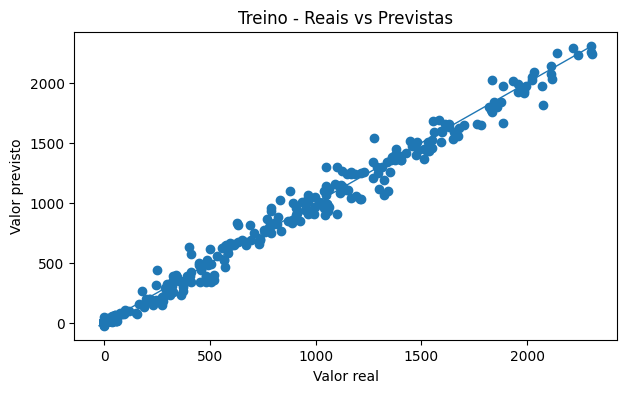

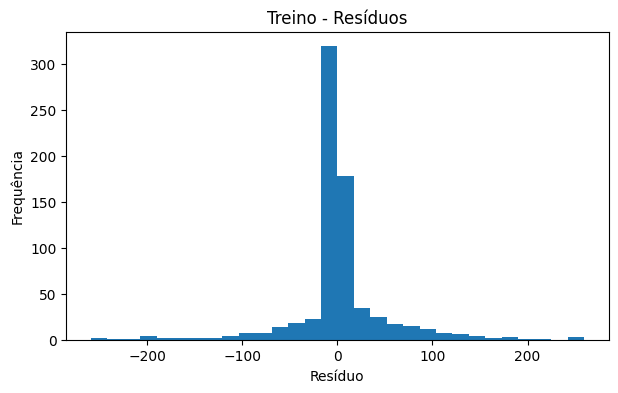

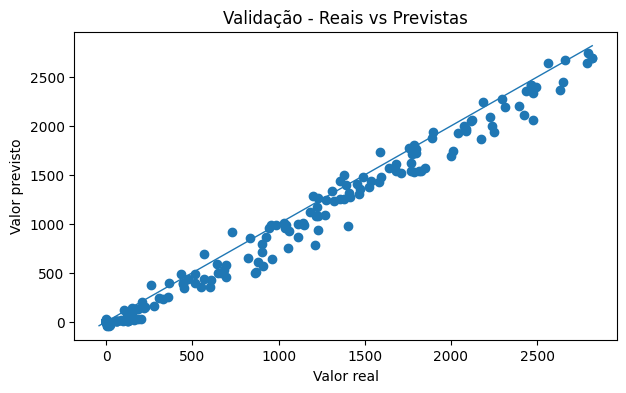

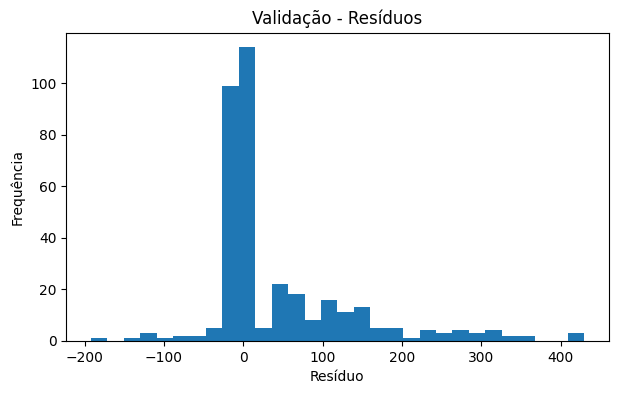

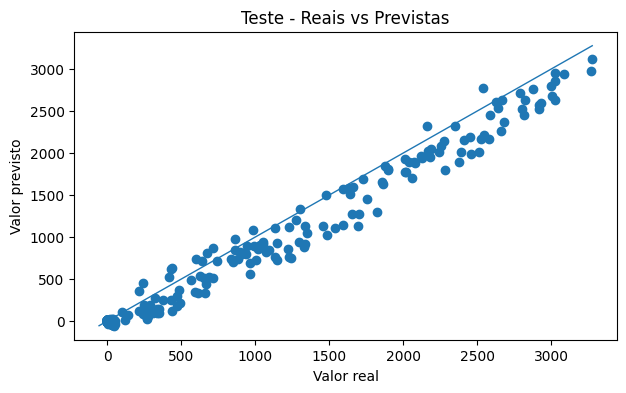

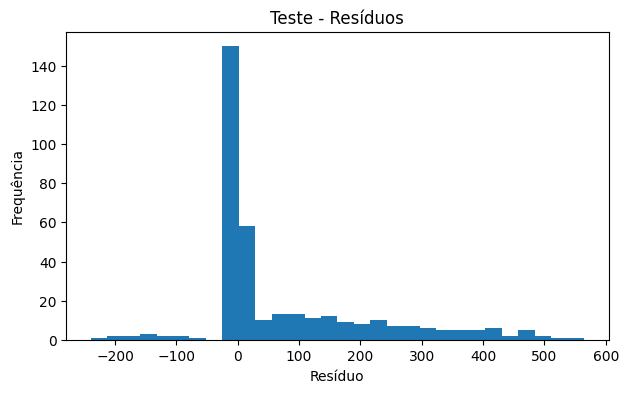

In [8]:
# Gráficos (um por célula)
def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(7,4))
    plt.scatter(y_true, y_pred)
    plt.xlabel('Valor real')
    plt.ylabel('Valor previsto')
    plt.title(title)
    mn = min(np.min(y_true), np.min(y_pred))
    mx = max(np.max(y_true), np.max(y_pred))
    plt.plot([mn,mx],[mn,mx], linewidth=1)
    plt.savefig(OUTPUT/ f'MLP - {title}.png')
    plt.show()

def plot_residuals_hist(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(7,4))
    plt.hist(residuals, bins=30)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(title)
    plt.savefig(OUTPUT/ f'MLP - {title}.png')
    plt.show()

# Treino
plot_actual_vs_pred(y_train, y_train_pred, 'Treino - Reais vs Previstas')
plot_residuals_hist(y_train, y_train_pred, 'Treino - Resíduos')

# Validação
plot_actual_vs_pred(y_val, y_val_pred, 'Validação - Reais vs Previstas')
plot_residuals_hist(y_val, y_val_pred, 'Validação - Resíduos')

# Teste
plot_actual_vs_pred(y_test, y_test_pred, 'Teste - Reais vs Previstas')
plot_residuals_hist(y_test, y_test_pred, 'Teste - Resíduos')

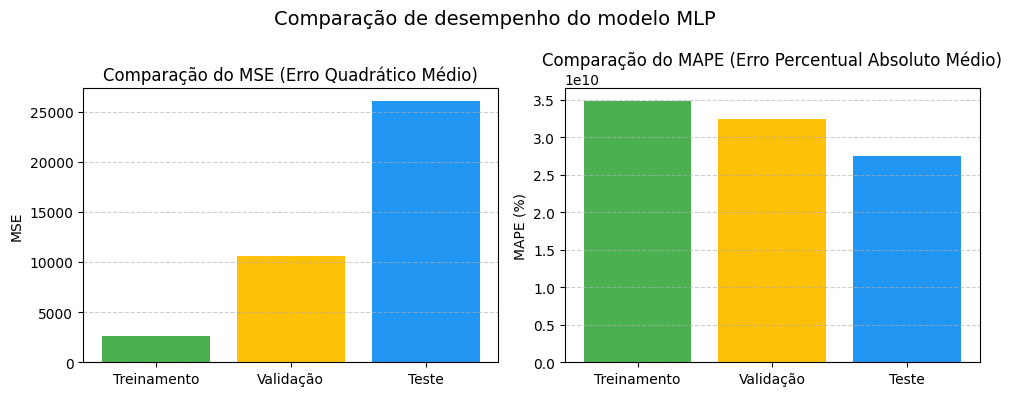

In [9]:
datasets = ['Treinamento', 'Validação', 'Teste']
mse_values = [mse_train, mse_val, mse_test]
mape_values = [mape_train, mape_val, mape_test]

# Criar figura com 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Gráfico 1: MSE ---
axes[0].bar(datasets, mse_values, color=['#4CAF50', '#FFC107', '#2196F3'])
axes[0].set_title('Comparação do MSE (Erro Quadrático Médio)')
axes[0].set_ylabel('MSE')
axes[0].grid(True, axis='y', linestyle='--', alpha=0.6)

# --- Gráfico 2: MAPE ---
axes[1].bar(datasets, mape_values, color=['#4CAF50', '#FFC107', '#2196F3'])
axes[1].set_title('Comparação do MAPE (Erro Percentual Absoluto Médio)')
axes[1].set_ylabel('MAPE (%)')
axes[1].grid(True, axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Comparação de desempenho do modelo MLP', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT / 'MLP - Comparação de desempenho do modelo.png')
plt.show()